In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../src")

In [3]:
import numpy as np
from tb import *
from hamiltonians import *

## Check 1: When we switch to the cluster basis, do we relabel and get the same k points? Do we get the same eigenstates?

In [4]:
N = 4
H = oned_chain_hamiltonian(N, J=1)#.reshape((1,1,N,N))
T = np.arange(N).reshape((N, 1))
b = 2*np.pi*np.linalg.inv([[1.]])
k = get_kpt_mesh((N,), b)
basis = np.eye(N).reshape((len(T), N, 1)) # number of translation vectors, total N, number of orbitals
chik = get_bloch_wavefunction(k, T, basis)

P = get_momentum_operator(chik, k.ravel())

In [5]:
np.allclose(H @ P - P @ H, 0.)

True

In [6]:
hcluster = oned_chain_hamiltonian(2, J=1)
_, u = np.linalg.eigh(hcluster)
U = np.block([[u, np.zeros(u.shape)],[np.zeros(u.shape), u]])
kp, ep, _  = basis_transform_and_relabel(H, [P], U, Norb=1)

assert np.allclose(kp.imag, 0.0)
kp = kp.real

In [8]:
print(k.ravel())
print(np.round(kp, 10).ravel())

[-1.57079633  0.          1.57079633  3.14159265]
[-1.57079633 -0.          1.57079633  3.14159265]


## Check 2: What happens when we start to truncate things?

### With truncation, just periodic BC

In [9]:
N = 128
H = oned_chain_hamiltonian(N, J=1)#.reshape((1,1,N,N))
T = np.arange(N).reshape((N, 1))
b = 2*np.pi*np.linalg.inv([[1.]])
k = get_kpt_mesh((N,), b)
basis = np.eye(N).reshape((len(T), N, 1)) # number of translation vectors, total N, number of orbitals
chik = get_bloch_wavefunction(k, T, basis)
Hk = expectation(chik, H)
ek = np.linalg.eigvalsh(Hk)

P = get_momentum_operator(chik, k.ravel())
P2 = P @ P

In [12]:
Nblocks = 4
assert N % Nblocks == 0
hcluster_p = oned_chain_hamiltonian(N//Nblocks, J=1, bc=1)
hcluster_a = oned_chain_hamiltonian(N//Nblocks, J=1, bc=-1)
ea, ua = np.linalg.eigh(hcluster_p)

u = ua[:, np.abs(ea) <= 1][:, :]

U = get_block_transformation_matrix(u, Nblocks)
print(U.shape)

(128, 40)


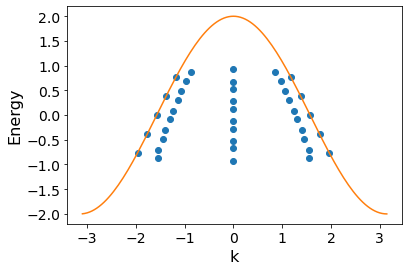

In [13]:
kp, ep, _  = basis_transform_and_relabel(H, [P], U, Norb=1)
#assert np.allclose(kp.imag, 0.0)
#kp = kp.real
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Energy", fontsize=16)
plt.xlabel("k", fontsize=16)
plt.scatter(kp, ep, )
plt.plot(k, ek, c='C1')
plt.savefig("img/1d_pbc_trunc_none.png", bbox_inches='tight')

## With periodic and antiperiodic BC

In [14]:
N = 128
H = oned_chain_hamiltonian(N, J=1)#.reshape((1,1,N,N))
T = np.arange(N).reshape((N, 1))
b = 2*np.pi*np.linalg.inv([[1.]])
k = get_kpt_mesh((N,), b)
basis = np.eye(N).reshape((len(T), N, 1)) # number of translation vectors, total N, number of orbitals
chik = get_bloch_wavefunction(k, T, basis)
Hk = expectation(chik, H)
ek = np.linalg.eigvalsh(Hk)

P = get_momentum_operator(chik, k.ravel())
P2 = P@P

In [15]:
Nblocks = 4

In [16]:
assert N % Nblocks == 0
hcluster_p = oned_chain_hamiltonian(N//Nblocks, J=1, bc=1)
hcluster_a = oned_chain_hamiltonian(N//Nblocks, J=1, bc=-1)
ea, ua = np.linalg.eigh(hcluster_p)
eb, ub = np.linalg.eigh(hcluster_a)
ecutoff = 1.

ua = ua[:, np.abs(ea) < ecutoff]
ub = ub[:, np.abs(eb) < ecutoff]

assert len(ua) + len(ub) > 0

u = np.concatenate([ua, ub], axis=1)
q, r = np.linalg.qr(u)

U = get_block_transformation_matrix(q, Nblocks)
print(U.shape)

(128, 88)


In [17]:
kp, ep, _ = basis_transform_and_relabel(H, [P], U, Norb=1)

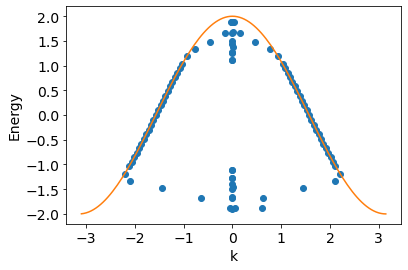

In [18]:
plt.scatter(kp, ep)
plt.plot(k, ek, c='C1')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("k", fontsize=14)
plt.ylabel("Energy", fontsize=14)
plt.savefig("img/1d_pbc_both_bc.png", bbox_inches='tight')

### Multiple blocks

In [19]:
N = 32
H = oned_chain_hamiltonian(N, J=1)#.reshape((1,1,N,N))
T = np.arange(N).reshape((N, 1))
b = 2*np.pi*np.linalg.inv([[1.]])
k = get_kpt_mesh((N,), b)
basis = np.eye(N).reshape((len(T), N, 1)) # number of translation vectors, total N, number of orbitals
chik = get_bloch_wavefunction(k, T, basis)
Hk = expectation(chik, H)
ek = np.linalg.eigvalsh(Hk)

P = get_momentum_operator(chik, k.ravel())
P2 = P@P

In [20]:
Nblocks = 4
Nperblock = N // Nblocks

In [25]:
T = Nperblock * np.arange(Nblocks).reshape((Nblocks, 1))
b = 2*np.pi*np.linalg.inv([[1.]])

hcluster_p = oned_chain_hamiltonian(N//Nblocks, J=1, bc=1)
hcluster_a = oned_chain_hamiltonian(N//Nblocks, J=1, bc=-1)

# k_block = get_kpt_mesh(N, 
# chik_small = get_bloch_wavefunction

ea, ua = np.linalg.eigh(hcluster_p)
eb, ub = np.linalg.eigh(hcluster_a)
                       
ecutoff = 1.

ua = ua[:, np.abs(ea) < ecutoff]
ub = ub[:, np.abs(eb) < ecutoff]

assert len(ua) + len(ub) > 0

u = np.concatenate([ua, ub], axis=1)
q, r = np.linalg.qr(u)

U = get_block_transformation_matrix(q, Nblocks)
print(U.shape)

(32, 24)


In [26]:
kp, ep, _ = basis_transform_and_relabel(H, [P], U, Norb=1)